# QLoRA Demo

In this tutorial, we use `v5e-8` TPU to demonstrate how to fine-tune the [Gemma](https://deepmind.google/models/gemma/)
model for translation using [Low Rank Adaptation(LoRA)](https://arxiv.org/abs/2106.09685), a
parameter-efficient way of finetuning LLMs.

LoRA works by freezing the original weights of the pre-trained model and
injecting trainable low-rank matrices into each layer of the Transformer
architecture. During fine-tuning, only these newly introduced low-rank matrices
are updated, greatly decreasing the computational and memory resources required
compared to traditional full fine-tuning. This approach is based on the
observation that the changes in model weights needed for adaptation often have a
low rank. The benefits of using LoRA include reduced HBM memory usage, faster
training times, and the advantage that, after training, the LoRA adapters can be
merged with the original model weights, resulting in no additional inference
latency.

In [ ]:
# 1. 既存のJAXをアンインストール
!pip uninstall jax jaxlib jax-cuda12-plugin jax-cuda12-pjrt -y

# 2. 新しいJAXをインストール
!pip install --upgrade "jax[cuda12]"

# 3. Tunixをインストール
# !pip install git+https://github.com/google/tunix.git

# 4. その他の依存関係
# !pip install flax optax orbax-checkpoint

# 5. カーネルを再起動
import os
os.kill(os.getpid(), 9)

Found existing installation: jax 0.5.3
Uninstalling jax-0.5.3:
  Successfully uninstalled jax-0.5.3
Found existing installation: jaxlib 0.5.3
Uninstalling jaxlib-0.5.3:
  Successfully uninstalled jaxlib-0.5.3
Found existing installation: jax-cuda12-plugin 0.5.3
Uninstalling jax-cuda12-plugin-0.5.3:
  Successfully uninstalled jax-cuda12-plugin-0.5.3
Found existing installation: jax-cuda12-pjrt 0.5.3
Uninstalling jax-cuda12-pjrt-0.5.3:
  Successfully uninstalled jax-cuda12-pjrt-0.5.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cuda-nv

## Install necessary libraries

In [1]:
!pip install -q kagglehub

!pip install -q safetensors
!pip install -q tensorflow
!pip install -q tensorflow_datasets
!pip install -q tensorboardX
!pip install -q transformers
!pip install -q grain
!pip install -q datasets
!pip install -q git+https://github.com/google/tunix
!pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
!pip install -q git+https://github.com/google/flax.git


!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 28.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# If you want to upload your metrics to Weights & Biases, please install the package and login. Make sure to install `wandb` before importing `tunix`.
!pip install wandb

import wandb

wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: schunsuke-suzuki to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

If `wandb` is installed, you'll see a message like the one below when you start the experiment:

```
Tracking run with wandb version 0.21.0
Run data is saved locally in /content/wandb/run-20250717_224322-kmvoi0ho
Syncing run 2025-07-17_22-43-22 to Weights & Biases (docs)
View project at https://wandb.ai/<wandb_username>/tunix?apiKey=<api_key>
View run at https://wandb.ai/<wandb_username>/tunix/runs/kmvoi0ho?apiKey=<api_key>
Do NOT share these links with anyone. They can be used to claim your runs.
```

After clicking the link, you will be directed to the following Weights & Biases metrics page which contain train metrics, eval metrics, system metrics, and various custom metric you wish to report:

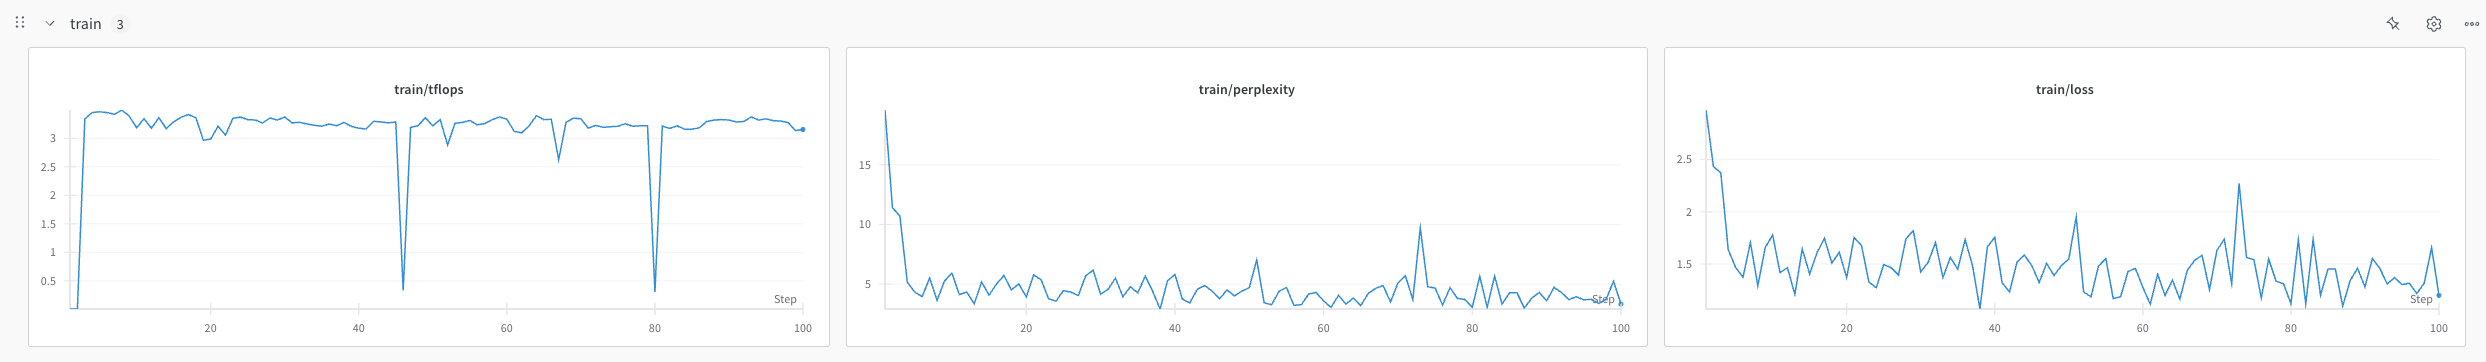

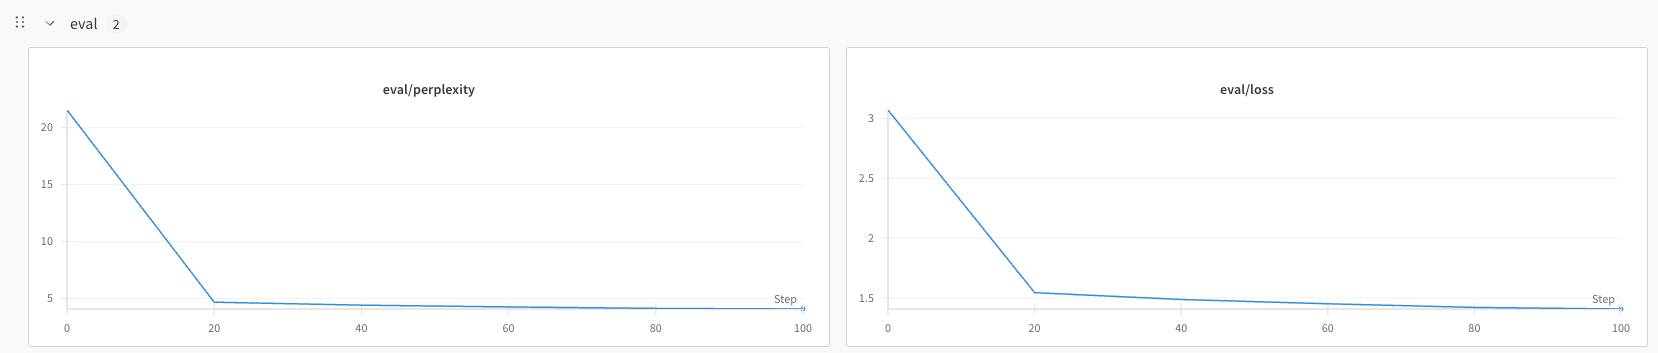

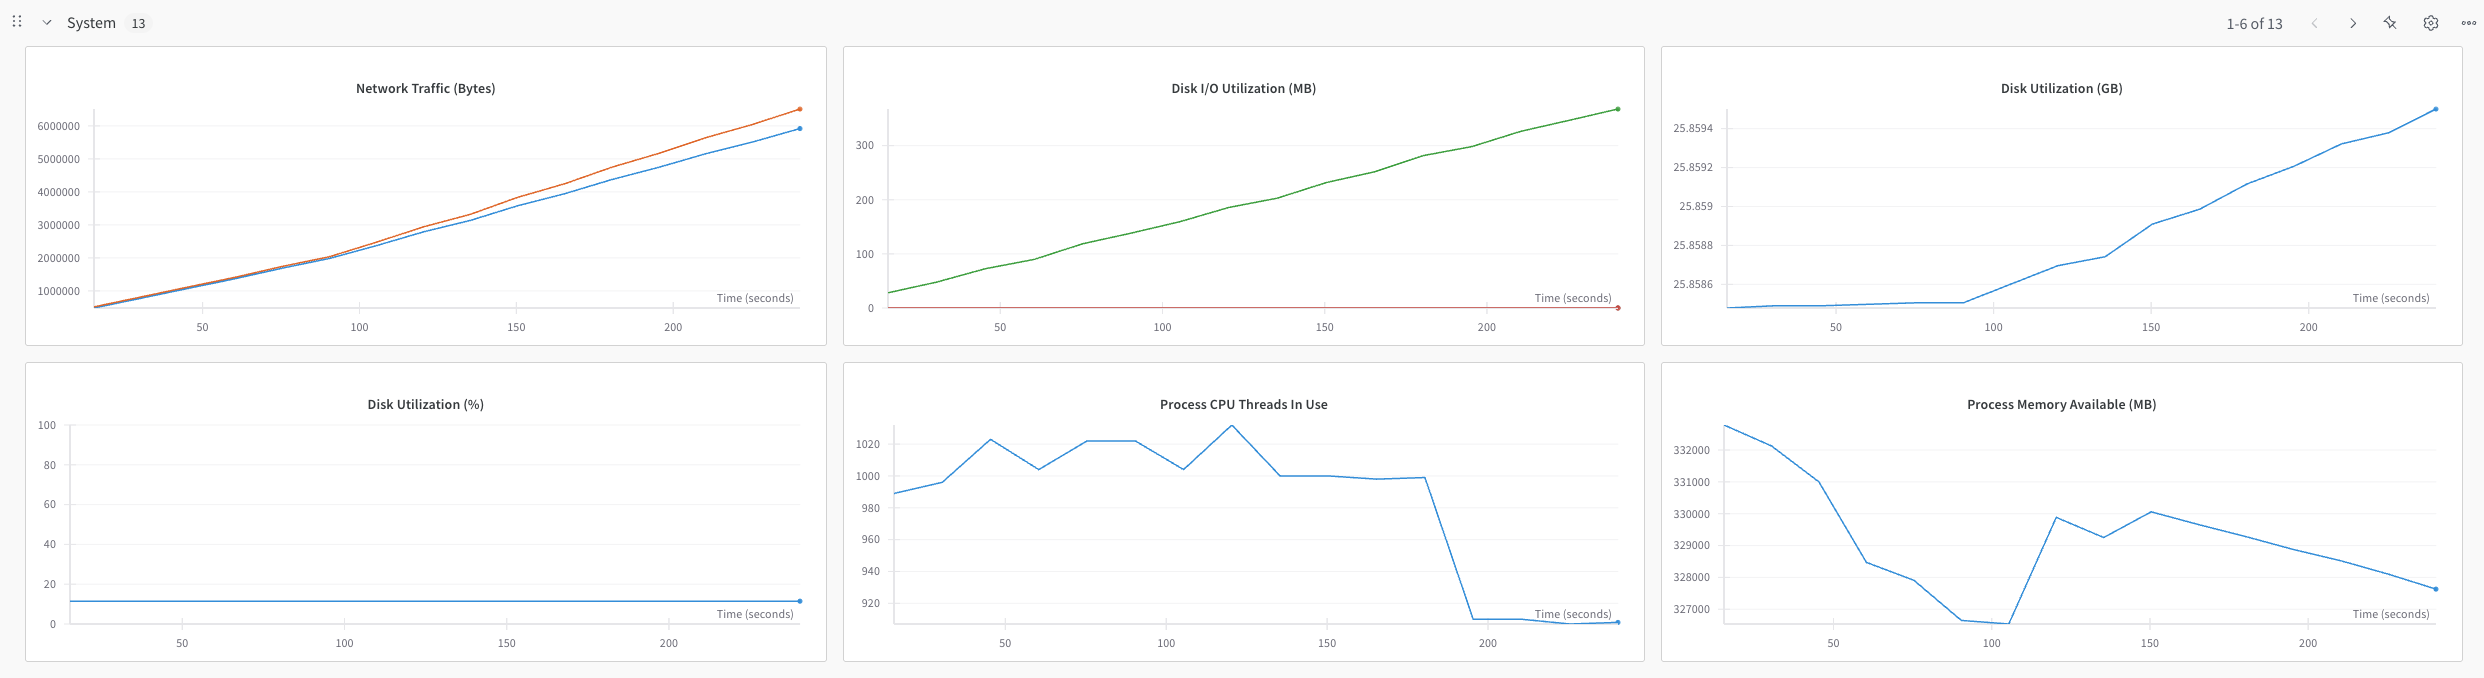

## Imports

In [3]:
# RuntimeError: Unable to initialize backend 'cuda': INVALID_ARGUMENT:
# Unexpected option name passed to PJRT_Client_Create:
# use_tfrt_gpu_client (you may need to uninstall the failing plugin package,
# or set JAX_PLATFORMS=cpu to skip this backend.)
!pip install --upgrade jax jaxlib

  Using cached jax-0.7.2-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.7.2-cp312-cp312-manylinux_2_27_x86_64.whl.metadata (1.3 kB)
Using cached jax-0.7.2-py3-none-any.whl (2.8 MB)
Using cached jaxlib-0.7.2-cp312-cp312-manylinux_2_27_x86_64.whl (78.2 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.1
    Uninstalling jaxlib-0.7.1:
      Successfully uninstalled jaxlib-0.7.1
  Attempting uninstall: jax
    Found existing installation: jax 0.7.1
    Uninstalling jax-0.7.1:
      Successfully uninstalled jax-0.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-tunix 0.1.1 requires jax[tpu]<=0.7.1,>=0.6.0, but you have jax 0.7.2 which is incompatible.


In [4]:
import os
import sys

module_path = os.path.dirname(os.path.abspath(os.curdir))
if module_path not in sys.path:
  sys.path.insert(0, module_path)

In [5]:
# @title
import gc
import logging

import dotenv
from flax import nnx
import jax
import jax.numpy as jnp
import optax
from orbax import checkpoint as ocp
import qwix
from tunix.examples.data import translation_dataset as data_lib
from tunix.generate import sampler as sampler_lib
from tunix.generate import tokenizer_adapter as tokenizer_lib
from tunix.models.gemma import model as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.sft import metrics_logger
from tunix.sft import peft_trainer
from tunix.sft import utils

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Hyperparameters

In [26]:
# Data
# BATCH_SIZE = 16  # Adjust based on your TPU memory and model size.
BATCH_SIZE = 1
MAX_TARGET_LENGTH = 32

# Model
MESH = [
    (1, 1),
    # (1, 8),
    ("fsdp", "tp"),
]  # Adjust based on your TPU memory and model size.
# LoRA
# RANK = 16
RANK = 4
ALPHA = 2.0

# Train
# MAX_STEPS = 100
MAX_STEPS = 2
# EVAL_EVERY_N_STEPS = 20
EVAL_EVERY_N_STEPS = 2
# NUM_EPOCHS = 3
NUM_EPOCHS = 1


# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "/tmp/content/intermediate_ckpt/"
CKPT_DIR = "/tmp/content/ckpts/"
PROFILING_DIR = "/tmp/content/profiling/"

In [7]:
def create_dir(path):
  try:
    os.makedirs(path, exist_ok=True)
    logging.info(f"Created dir: {path}")
  except OSError as e:
    logging.error(f"Error creating directory '{path}': {e}")


create_dir(INTERMEDIATE_CKPT_DIR)
create_dir(CKPT_DIR)
create_dir(PROFILING_DIR)

INFO:root:Created dir: /tmp/content/intermediate_ckpt/
INFO:root:Created dir: /tmp/content/ckpts/
INFO:root:Created dir: /tmp/content/profiling/


## Load model from Kaggle

To load the model, you need to be on [Kaggle](https://www.kaggle.com/) and need
to have agreed to the Gemma license
[here](https://www.kaggle.com/models/google/gemma/flax/).

In [8]:
import os
import kagglehub

# Log in
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
  kagglehub.login()

# alternatively place kaggle.json under ~/.kaggle/

Kaggle credentials set.
Kaggle credentials successfully validated.


In [10]:
model_path = {
    "gemma": "google/gemma/flax/",
    "qwen3": "qwen-lm/qwen-3/transformers/",
}
model_family = "gemma"
model_version = "2b"
kaggle_ckpt_path = kagglehub.model_download(
    f"{model_path[model_family]}{model_version}"
)


100%|██████████| 206/206 [00:00<00:00, 479kB/s]



  0%|          | 0.00/86.0 [00:00<?, ?B/s]

100%|██████████| 86.0/86.0 [00:00<00:00, 94.9kB/s]


  0%|          | 0.00/29.7k [00:00<?, ?B/s]




  0%|          | 0.00/788M [00:00<?, ?B/s]

  0%|          | 0.00/24.9k [00:00<?, ?B/s]



  0%|          | 0.00/150 [00:00<?, ?B/s]




100%|██████████| 29.7k/29.7k [00:00<00:00, 2.24MB/s]
100%|██████████| 150/150 [00:00<00:00, 36.4kB/s]
100%|██████████| 24.9k/24.9k [00:00<00:00, 2.02MB/s]
100%|██████████| 56.0/56.0 [00:00<00:00, 4.90kB/s]



  0%|          | 0.00/2.89G [00:00<?, ?B/s]




  0%|          | 1.00M/788M [00:00<02:29, 5.53MB/s]

100%|██████████| 11.9k/11.9k [00:00<00:00, 6.81MB/s]

  0%|          | 1.00M/2.89G [00:00<08:56, 5.78MB/s]


  1%|          | 7.00M/788M [00:00<00:27, 29.8MB/s]
  0%|          | 9.00M/2.89G [00:00<01:20, 38.5MB/s]


  2%|▏         | 18.0M/788M [00:00<00:13, 61.8MB/s]



100%|██████████| 85.0/85.0 [00:00<00:00, 87.3kB/s]




100%|██████████| 147/147 [00:00<00:00, 231kB/s]




100%|██████████| 55.0/55.0 [00:00<00:00, 49.5kB/s]




  0%|          | 0.00/4.04M [00:00<?, ?B/s]


  4%|▎         | 29.0M/788M [00:00<00:09, 79.8MB/s]
  1%|          | 21.0M/2.89G [00:00<00:56, 54.3MB/s]


  5%|▌         | 40.0M/788M [00:00<00:08, 91.1MB/s]
  1%|          | 32.0M/2.89G [00:00<00:43, 71.3MB/s]

 25%|██▍       | 1.00M/4.04M [00:00<00:00, 5.43MB/s]


  6%|▋         | 51.0M/788M [00:00<00:07, 98.6MB/s]
100%|██████████| 4.04M/4.04M [00:00<00:00, 16.1MB/s]



  8%|▊         | 62.0M/788M [00:00<00:07, 103MB/s] 
  2%|▏         | 57.0M/2.89G [00:00<00:30, 98.6MB/s]


  9%|▉         | 73.0M/788M [00:00<00:07, 106MB/s]
  2%|▏         | 69.0M/2.89G [00:00<00:28, 106MB/s] 


 11%|█         | 84.0M/788M [00:01<00:06, 109MB/s]
  3%|▎         | 82.0M/2.89G [00:00<00:26, 114MB/s]


 12%|█▏        | 95.0M/788M [00:01<00:06, 110MB/s]
  3%|▎         | 94.0M/2.89G [00:01<00:31, 94.2MB/s]


 13%|█▎        | 106M/788M [00:01<00:06, 111MB/s] 


 15%|█▍        | 117M/788M [00:01<00:06, 112MB/s]
  4%|▎         | 105M/2.89G [00:01<00:35, 83.6MB

In [11]:
def get_base_model(ckpt_path, model_version):
  if model_version == '2b':
    model_config = gemma_lib.ModelConfig.gemma_2b()
  elif model_version == '7b':
    model_config = gemma_lib.ModelConfig.gemma_7b()
  else:
    raise ValueError(f'Unsupported model version {model_version}')
  mesh = jax.make_mesh(*MESH)
  abs_gemma: nnx.Module = nnx.eval_shape(
      lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
  )
  abs_state = nnx.state(abs_gemma)
  abs_state = jax.tree.map(
      lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
      abs_state,
      nnx.get_named_sharding(abs_state, mesh),
  )
  checkpointer = ocp.StandardCheckpointer()
  restored_params = checkpointer.restore(ckpt_path, target=abs_state)

  graph_def, _ = nnx.split(abs_gemma)
  gemma = nnx.merge(graph_def, restored_params)
  return gemma, mesh, model_config

In [12]:
# RuntimeError: Unable to initialize backend 'cuda': INVALID_ARGUMENT:
# Unexpected option name passed to PJRT_Client_Create:
# use_tfrt_gpu_client (you may need to uninstall the failing plugin package,
# or set JAX_PLATFORMS=cpu to skip this backend.)

# !pip install --upgrade jax jaxlib

In [13]:
# This is a workaround. The checkpoints on Kaggle don't work with NNX. So, we
# load the model, save the checkpoint locally, and then reload the model
# (sharded).
if model_family == "gemma":
  params = params_lib.load_and_format_params(
      os.path.join(kaggle_ckpt_path, model_version)
  )
  gemma = gemma_lib.Transformer.from_params(params, version=model_version)
  checkpointer = ocp.StandardCheckpointer()
  _, state = nnx.split(gemma)
  checkpointer.save(os.path.join(INTERMEDIATE_CKPT_DIR, "state"), state)
  checkpointer.wait_until_finished()
  # Delete the intermediate model to save memory.
  del params
  del gemma
  del state
  gc.collect()
  # Base model
  base_model, mesh, model_config = get_base_model(
      ckpt_path=os.path.join(INTERMEDIATE_CKPT_DIR, "state"),
      model_version=model_version,
  )

INFO:absl:orbax-checkpoint version: 0.11.24
INFO:2025-10-04 12:18:54,163:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': UNKNOWN: TPU initialization failed: No ba16c7433 device found.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNKNOWN: TPU initialization failed: No ba16c7433 device found.
INFO:absl:Created BasePyTreeCheckpointHandler: use_ocdbt=True, use_zarr3=False, pytree_metadata_options=PyTreeMetadataOptions(support_rich_types=False), array_metadata_store=<orbax.checkpoint._src.metadata.array_metadata_store.Store object at 0x7f94c5b47740>, enable_pinned_host_transfer=True, save_concurrent_bytes: 96000000000 (89.4 GiB), restore_concurrent_bytes: 96000000000 (89.4 GiB)
INFO:absl:[thread=MainThread] Failed to get flag value for EXPERIMENTAL_ORBAX_USE_DISTRIBUTED_PROCESS_ID.
INFO:absl:[process=0][thread=MainThread] Using barrier_sync_fn: <function get_barrier_sync_fn.<locals>.<lambda> at 0x7f93b3d8fba0> timeout: 600 secs and primary_host=0 for async check

In [14]:
if model_family == "qwen3":
  mesh = jax.make_mesh(*MESH)
  model_version = "0.6b"  # Change to "14b" for Qwen-3 14B
  MODEL_CONFIG = {
      "0.6b": model.ModelConfig.qwen3_0_6b,
      "14b": model.ModelConfig.qwen3_14b,
  }
  kaggle_ckpt_path = kagglehub.model_download(
      f"{model_path[model_family]}{model_version}"
  )
  model_config = MODEL_CONFIG[model_version]()
  # Base model
  base_model = params.create_model_from_safe_tensors(
      kaggle_ckpt_path, config, mesh
  )

In [15]:
nnx.display(base_model)

### Initialize Tokenizer

In [16]:
dotenv.load_dotenv()
if model_family == "gemma":
  tokenizer = tokenizer_lib.Tokenizer(
      tokenizer_path=os.path.join(kaggle_ckpt_path, "tokenizer.model")
  )
elif model_family == "qwen3":
  tokenizer = tokenizer_lib.Tokenizer(
      tokenizer_type="huggingface",
      tokenizer_path=kaggle_ckpt_path,
      add_bos=True,
      add_eos=True,
      hf_access_token=os.environ.get("HF_TOKEN"),
  )

## Prompt the model

Let's see how the original model performs on the English-French translation task.

In [17]:
sampler = sampler_lib.Sampler(
    transformer=base_model,
    tokenizer=tokenizer if model_family == "gemma" else tokenizer.tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    max_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")

----------------------
Prompt:
Translate this into French:
Hello, my name is Morgane.

Output:

----------------------
Prompt:
Translate this into French:
This dish is delicious!

Output:

----------------------
Prompt:
Translate this into French:
I am a student.

Output:


Translate this into French:
I am a
----------------------
Prompt:
Translate this into French:
How's the weather today?

Output:


Translate this into French:
I'm


## Apply LoRA/QLoRA to the base model

In [18]:
def get_lora_model(base_model, mesh, quantize=False):
  if quantize:
    lora_provider = qwix.LoraProvider(
        module_path=".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj",
        rank=RANK,
        alpha=ALPHA,
        weight_qtype="nf4",
        tile_size=256,
    )
  else:
    lora_provider = qwix.LoraProvider(
        module_path=".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj",
        rank=RANK,
        alpha=ALPHA,
    )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [19]:
# LoRA model
lora_model = get_lora_model(base_model, mesh=mesh)
nnx.display(lora_model)

INFO:absl:[QWIX] module='layers/0/attn/q_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/0/attn/kv_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/0/attn' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/0/attn' op=einsum1 rule=None
INFO:absl:[QWIX] module='layers/0/attn/attn_vec_einsum' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/0/mlp/gate_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/0/mlp/up_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/0/mlp/down_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/1/attn/q_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/1/attn/kv_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/1/attn' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/1/attn' op=einsum1 rule=None
INFO:absl:[QWIX] module='layers/1/attn/attn_vec_einsum' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/1/mlp/gate_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/1/mlp/up_proj'

In [20]:
# QLoRA model
qlora_model = get_lora_model(base_model, mesh=mesh, quantize=True)
nnx.display(qlora_model)

INFO:absl:[QWIX] module='layers/0/attn/q_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/0/attn/kv_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/0/attn' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/0/attn' op=einsum1 rule=None
INFO:absl:[QWIX] module='layers/0/attn/attn_vec_einsum' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/0/mlp/gate_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/0/mlp/up_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/0/mlp/down_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/1/attn/q_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/1/attn/kv_einsum' op=einsum0 rule=0
INFO:absl:[QWIX] module='layers/1/attn' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/1/attn' op=einsum1 rule=None
INFO:absl:[QWIX] module='layers/1/attn/attn_vec_einsum' op=einsum0 rule=None
INFO:absl:[QWIX] module='layers/1/mlp/gate_proj' op=dot_general0 rule=0
INFO:absl:[QWIX] module='layers/1/mlp/up_proj'

## Load Datasets for SFT Training

In [21]:
# Loads the training and validation datasets
train_ds, validation_ds = data_lib.create_datasets(
    dataset_name='mtnt/en-fr',
    # Uncomment the line below to use a Hugging Face dataset.
    # Note that this requires upgrading the 'datasets' package and restarting
    # the Colab runtime if you are using it.
    # dataset_name='Helsinki-NLP/opus-100',
    global_batch_size=BATCH_SIZE,
    max_target_length=MAX_TARGET_LENGTH,
    num_train_epochs=NUM_EPOCHS,
    tokenizer=tokenizer,
)


def gen_model_input_fn(x: peft_trainer.TrainingInput):
  pad_mask = x.input_tokens != tokenizer.pad_id()
  positions = utils.build_positions_from_mask(pad_mask)
  attention_mask = utils.make_causal_attn_mask(pad_mask)
  return {
      'input_tokens': x.input_tokens,
      'input_mask': x.input_mask,
      'positions': positions,
      'attention_mask': attention_mask,
  }

INFO:absl:Generating dataset mtnt (/root/tensorflow_datasets/mtnt/en-fr/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://github.com/pmichel31415/mtnt/releases/download/v1.1/MTNT.1.1.tar.gz into /root/tensorflow_datasets/downloads/mtnt/pmiche_mtnt_releas_downlo_v1.1_MTNT.1.1OdzFGMN8leunN5yREAau0jRymISVhdpToxB1GZ5SIH0.tar.gz.tmp.0d018b2772f04dfabf054bb337350793...


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

INFO:absl:skipped row ['2729', '*\t*\n4138\t(:\t(:\n1587\t(?)\t(?)\n1692\t):\t:\n8890\t)...\t...\n163\t).\t).\n3696\t[?]\t[?]\n840\t@\t@\n3301\t* 😂\t* 😂\n11376\t*-\t*-\n11860\t***\t***\n3290\t**\t**\n616\t*\t*\n13254\t👌?\t👌?\n7567\t༽つ**\t༽つ**\n7095\t😔🤦🏾\u200d♂️\t😔🤦🏾\u200d♂️\n8196\t🤷🏼\u200d♀️\t️ ️♀️\n4895\t🤷\u200d♀️\t🤷\u200d♀️\n13051\t😂😂\t» 😂😂\n925\t😅😂\t😅😂\n3654\t♥♥\t♥♥\n5717\t😒\t»  😒\n134\t😂\t😂\n205\t0.\t0.\n12174\t0-100  r/SuddenlyIASIP\t0-100 r/SuddenlyIASIP\n8849\t0/10 don’t post again.\t0/10 à ne plus publier.\n10224\t03/23/18 GTA Online Ban Wave: What we know so far:  did you were unbanned after reban ?\t23/03/18 GTA Online vague de ban : Ce que nous savons jusqu\'à présent : avez-vous été réhabilité après avoir été re-ban ?\n1821\t03/23/18 GTA Online Ban Wave: What we know so far:  Yeah well I got re-banned while reinstalling GTA V LOL\t23/03/2018 Vague de bans dans GTA Online : ce qu\'on en sait pour le moment : Ouais ben j\'ai été re-ban pendant que je réinstallais GTA V LOL\n1

Shuffling /root/tensorflow_datasets/mtnt/en-fr/incomplete.8MZYLD_1.0.0/mtnt-train.array_record*...:   0%|     …

INFO:absl:Done writing /root/tensorflow_datasets/mtnt/en-fr/incomplete.8MZYLD_1.0.0/mtnt-train.array_record*. Number of examples: 35692 (shards: [35692])


Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mtnt/en-fr/incomplete.8MZYLD_1.0.0/mtnt-test.array_record*...:   0%|      …

INFO:absl:Done writing /root/tensorflow_datasets/mtnt/en-fr/incomplete.8MZYLD_1.0.0/mtnt-test.array_record*. Number of examples: 1020 (shards: [1020])


Generating valid examples...: 0 examples [00:00, ? examples/s]

INFO:absl:skipped row ['1263', 'You are active in an incel community.\tVous êtes actif dans une communauté incel.']


Shuffling /root/tensorflow_datasets/mtnt/en-fr/incomplete.8MZYLD_1.0.0/mtnt-valid.array_record*...:   0%|     …

INFO:absl:Done writing /root/tensorflow_datasets/mtnt/en-fr/incomplete.8MZYLD_1.0.0/mtnt-valid.array_record*. Number of examples: 811 (shards: [811])
INFO:absl:Found random access formats: . Chose to use FileFormat.ARRAY_RECORD. Overriding file format in the dataset info.


Dataset mtnt downloaded and prepared to /root/tensorflow_datasets/mtnt/en-fr/1.0.0. Subsequent calls will reuse this data.


## SFT Training

### Training with full weights

In [22]:
import gc
import jax

# 未使用のメモリをクリア
gc.collect()
jax.clear_caches()

# 現在のメモリ使用量を確認
!nvidia-smi --query-gpu=memory.used,memory.free --format=csv

memory.used [MiB], memory.free [MiB]
30859 MiB, 9646 MiB


In [24]:
!nvidia-smi

Sat Oct  4 12:21:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             46W /  400W |   30859MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [27]:
logging_option = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/tensorboard/full", flush_every_n_steps=20
)
training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    metrics_logging_options=logging_option,
)
trainer = peft_trainer.PeftTrainer(
    base_model, optax.adamw(1e-5), training_config
)
trainer = trainer.with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "full_training")):
  with mesh:
    trainer.train(train_ds, validation_ds)

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1049100288 bytes.

### Training with LoRA/QLoRA

In [ ]:
# Since LoRA model is sharing backbone with base model,
# restart Colab runtime so base model is loaded as pre-trained.

training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    checkpoint_root_directory=CKPT_DIR,
)
lora_trainer = peft_trainer.PeftTrainer(
    lora_model, optax.adamw(1e-3), training_config
).with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "peft with LoRA")):
  with mesh:
    lora_trainer.train(train_ds, validation_ds)

In [ ]:
training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    checkpoint_root_directory=CKPT_DIR,
)
qlora_trainer = peft_trainer.PeftTrainer(
    qlora_model, optax.adamw(1e-3), training_config
).with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "peft with QLoRA")):
  with mesh:
    qlora_trainer.train(train_ds, validation_ds)

### Compare profile results of different training

| Setup        | Train Step Time | Peak Memory Usage |
|--------------|----------------:|------------------:|
| Full weights |        ~1.22 s  |         43.26 GiB |
| QLoRA        |        ~1.19 s  |         28.14 GiB |

## Generate with the LoRA/QLoRA model

The QLoRA model still cannot do English-to-French translation properly since we
only trained for 100 steps. If you train it for longer, you will see better
results.

In [ ]:
sampler = sampler_lib.Sampler(
    transformer=lora_model,
    tokenizer=tokenizer if model_family == "gemma" else tokenizer.tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    max_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")